In [1]:
import pandas as pd
from src.skill import (
    skill_extract, 
    skill_extract＿lm_ner,
    plot_frequency_wordcloud,
    plot_frequency_histogram)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
import pandas as pd
from transformers import pipeline
from tqdm import tqdm
import textwrap
import re
import ast
from collections import Counter
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from src.utils import load_data

# ======================================== These codes are from text_clustering.py in Tomasz's code =========================================

def words_to_sentence(word_list):
    return " ".join(ast.literal_eval(word_list))
# ============================================================================================================================================

def count_words(words):
    nlp = spacy.load("en_core_web_sm")
    words = [token.lemma_ for token in nlp(" ".join(words))]
    word_counts = Counter(words)
    return dict(word_counts)

def skill_extract＿lm_ner(cluster_dict):
    """
    Take a dictionary including the id and their cluster label. Extract skills and knowledge from the 
    raw job description using pretrained model: https://huggingface.co/algiraldohe/lm-ner-linkedin-skills-recognition

    Args:
      cluster_dict: A dictionary with a key of id and a value of its corresponding cluster label 

    Returns:
      returns a dictionary with a key of cluster label and a value of the extracted skills.
    """
    # Load the data
    df  = load_data(kind="processed")
    df["description"] = df["description"].apply(words_to_sentence)
    pipe = pipeline("token-classification", model="src/model/lm-ner-linkedin-skills-recognition")
    cluster_skill = {}
    for label in tqdm(set(cluster_dict.values())):
        skills = []
        ids = [key for key, value in cluster_dict.items() if value == label]
        for id in ids:
            description = df.loc[df['id'] == id]['description'].values[0]
            skills.extend(pipe(description)) 
        cluster_skill[label] = count_words(entry['word'] for entry in skills)
    return cluster_skill

 
def skill_extract(cluster_dict):
    """
    Take a dictionary including the id and their cluster label. Extract skills and knowledge from the 
    raw job description using pretrained model: https://huggingface.co/spaces/jjzha/skill_extraction_demo

    Args:
      cluster_dict: A dictionary with a key of id and a value of its corresponding cluster label 

    Returns:
      returns a dictionary with a key of cluster label and a value of the extracted skills.
    """
    # Load the data
    df  = load_data(kind="processed")
    
    df["description"] = df["description"].apply(words_to_sentence)
    token_skill_classifier = pipeline("token-classification", model="src/model/jobbert_skill_extraction", aggregation_strategy="first")
    token_knowledge_classifier = pipeline("token-classification", model="src/model/jobbert_knowledge_extraction", aggregation_strategy="first")
    
    cluster_skill = {}
    for label in tqdm(set(cluster_dict.values())):

        skills = []
        ids = [key for key, value in cluster_dict.items() if value == label]
        for id in ids:
            description = df.loc[df['id'] == id]['description'].values[0]
            lines = textwrap.wrap(description, 500, break_long_words=False)
        
            [skills.extend(skill) for skill in token_skill_classifier(lines)]
            [skills.extend(knowledge) for knowledge in token_knowledge_classifier(lines)]
         
        cluster_skill[label] = count_words(entry['word'] for entry in skills)
    return cluster_skill



def plot_frequency_wordcloud(skills, filename):
    # Create subplots
    num_subplots = len(skills)
    num_cols = 2  # Number of columns in the subplot grid
    num_rows = -(-num_subplots // num_cols)  # Ceiling division to determine the number of rows

    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 3 * num_rows))
    fig.suptitle('Word Cloud Subplots', fontsize=16)

    # Flatten the axs array for easier indexing
    axs = axs.flatten()

    # Generate word clouds for each inner dictionary and plot on a subplot
    for i, (key, word_frequency) in enumerate(skills.items()):
        ax = axs[i]
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequency)
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')
        ax.set_title(f' Cluster {key}')

    # Remove empty subplots if needed
    for j in range(i + 1, num_rows * num_cols):
        fig.delaxes(axs[j])

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Show the plot
    fig.savefig('figures/'+filename)

def plot_frequency_histogram(skills,filename,top_n=5):
    # Create subplots
    fig, axs = plt.subplots(nrows=10, ncols=2, figsize=(20, 40))
    fig.suptitle('Word Frequency in each cluster', fontsize=20)

    # Flatten the axs array for easier indexing
    axs = axs.flatten()

    # Plot each dictionary on a subplot
    for i, (key, word_frequency) in enumerate(skills.items()):
        sorted_word_frequency = sorted(word_frequency.items(), key=lambda x: x[1], reverse=True)
        top_words = dict(sorted_word_frequency[:top_n])

        words = list(top_words.keys())
        frequencies = list(top_words.values())

        axs[i].bar(words, frequencies)
        axs[i].set_ylabel('Frequencies')
        axs[i].set_title(f'Top {top_n} Word Frequency')
        axs[i].set_title(f'Cluster{key}')

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Show the plot
    fig.savefig('figures/'+filename)


In [23]:
file = pd.read_csv('clusters/ground_truth.csv', sep=',')

# Given a dictionary in the format of "id": "cluster label", and return a dictionary 
# of "cluster label": "skills"
skills = skill_extract(dict(zip(file["id"], file["cluster"])))
skills_lm = skill_extract_lm_ner(dict(zip(file["id"], file["cluster"])))

  0%|          | 0/20 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
100%|██████████| 20/20 [02:12<00:00,  6.62s/it]


In [24]:
#Save files

pd.DataFrame.from_dict(skills.items()).to_csv("./csv_files/ground_skills.csv",header=False, index=False)
pd.DataFrame.from_dict(skills_lm.items()).to_csv("./csv_files/ground_skills_lm.csv",header=False, index=False)

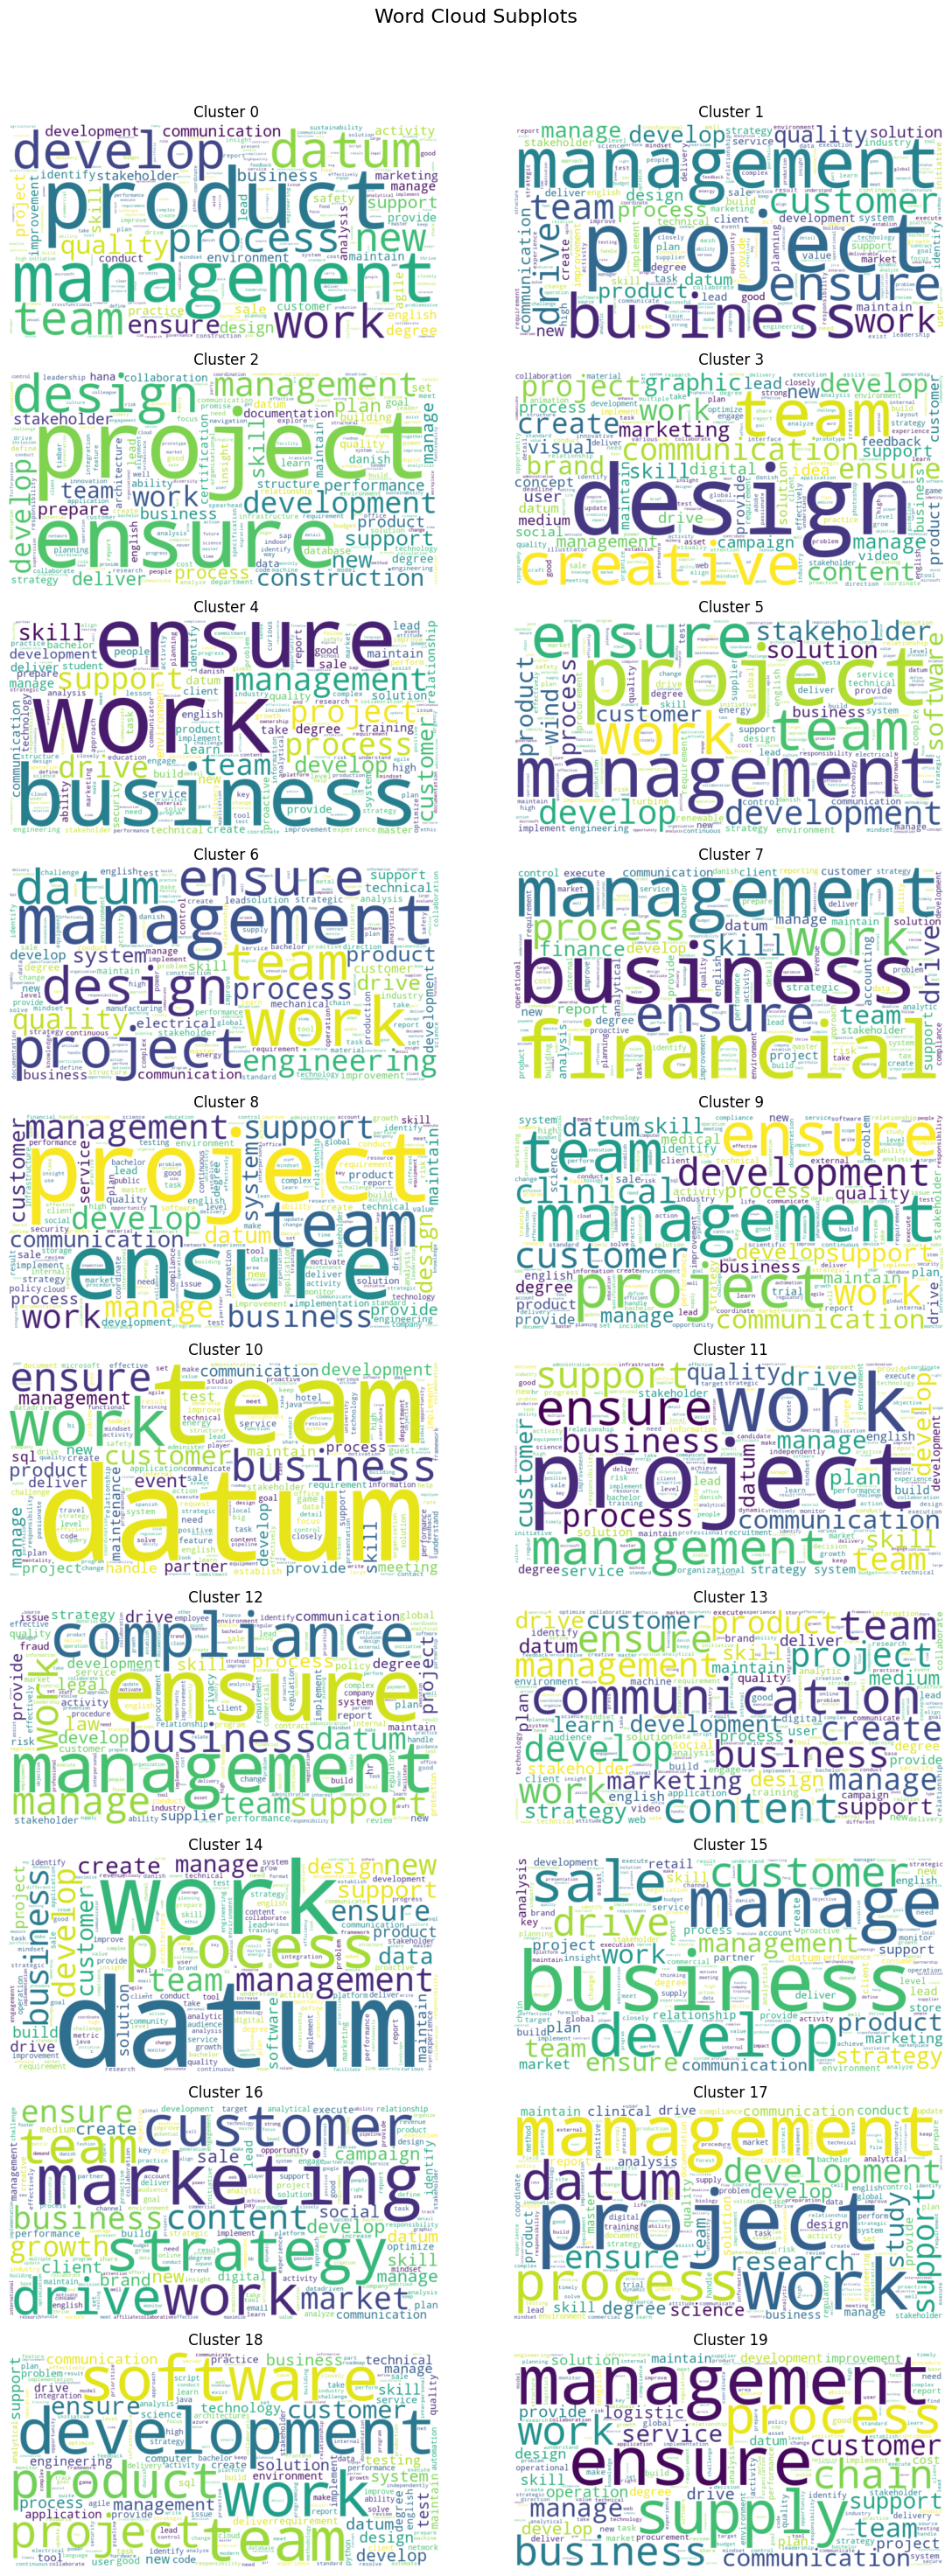

In [25]:
plot_frequency_wordcloud(skills, 'wordfrequency_wordcloud_ground.jpg')

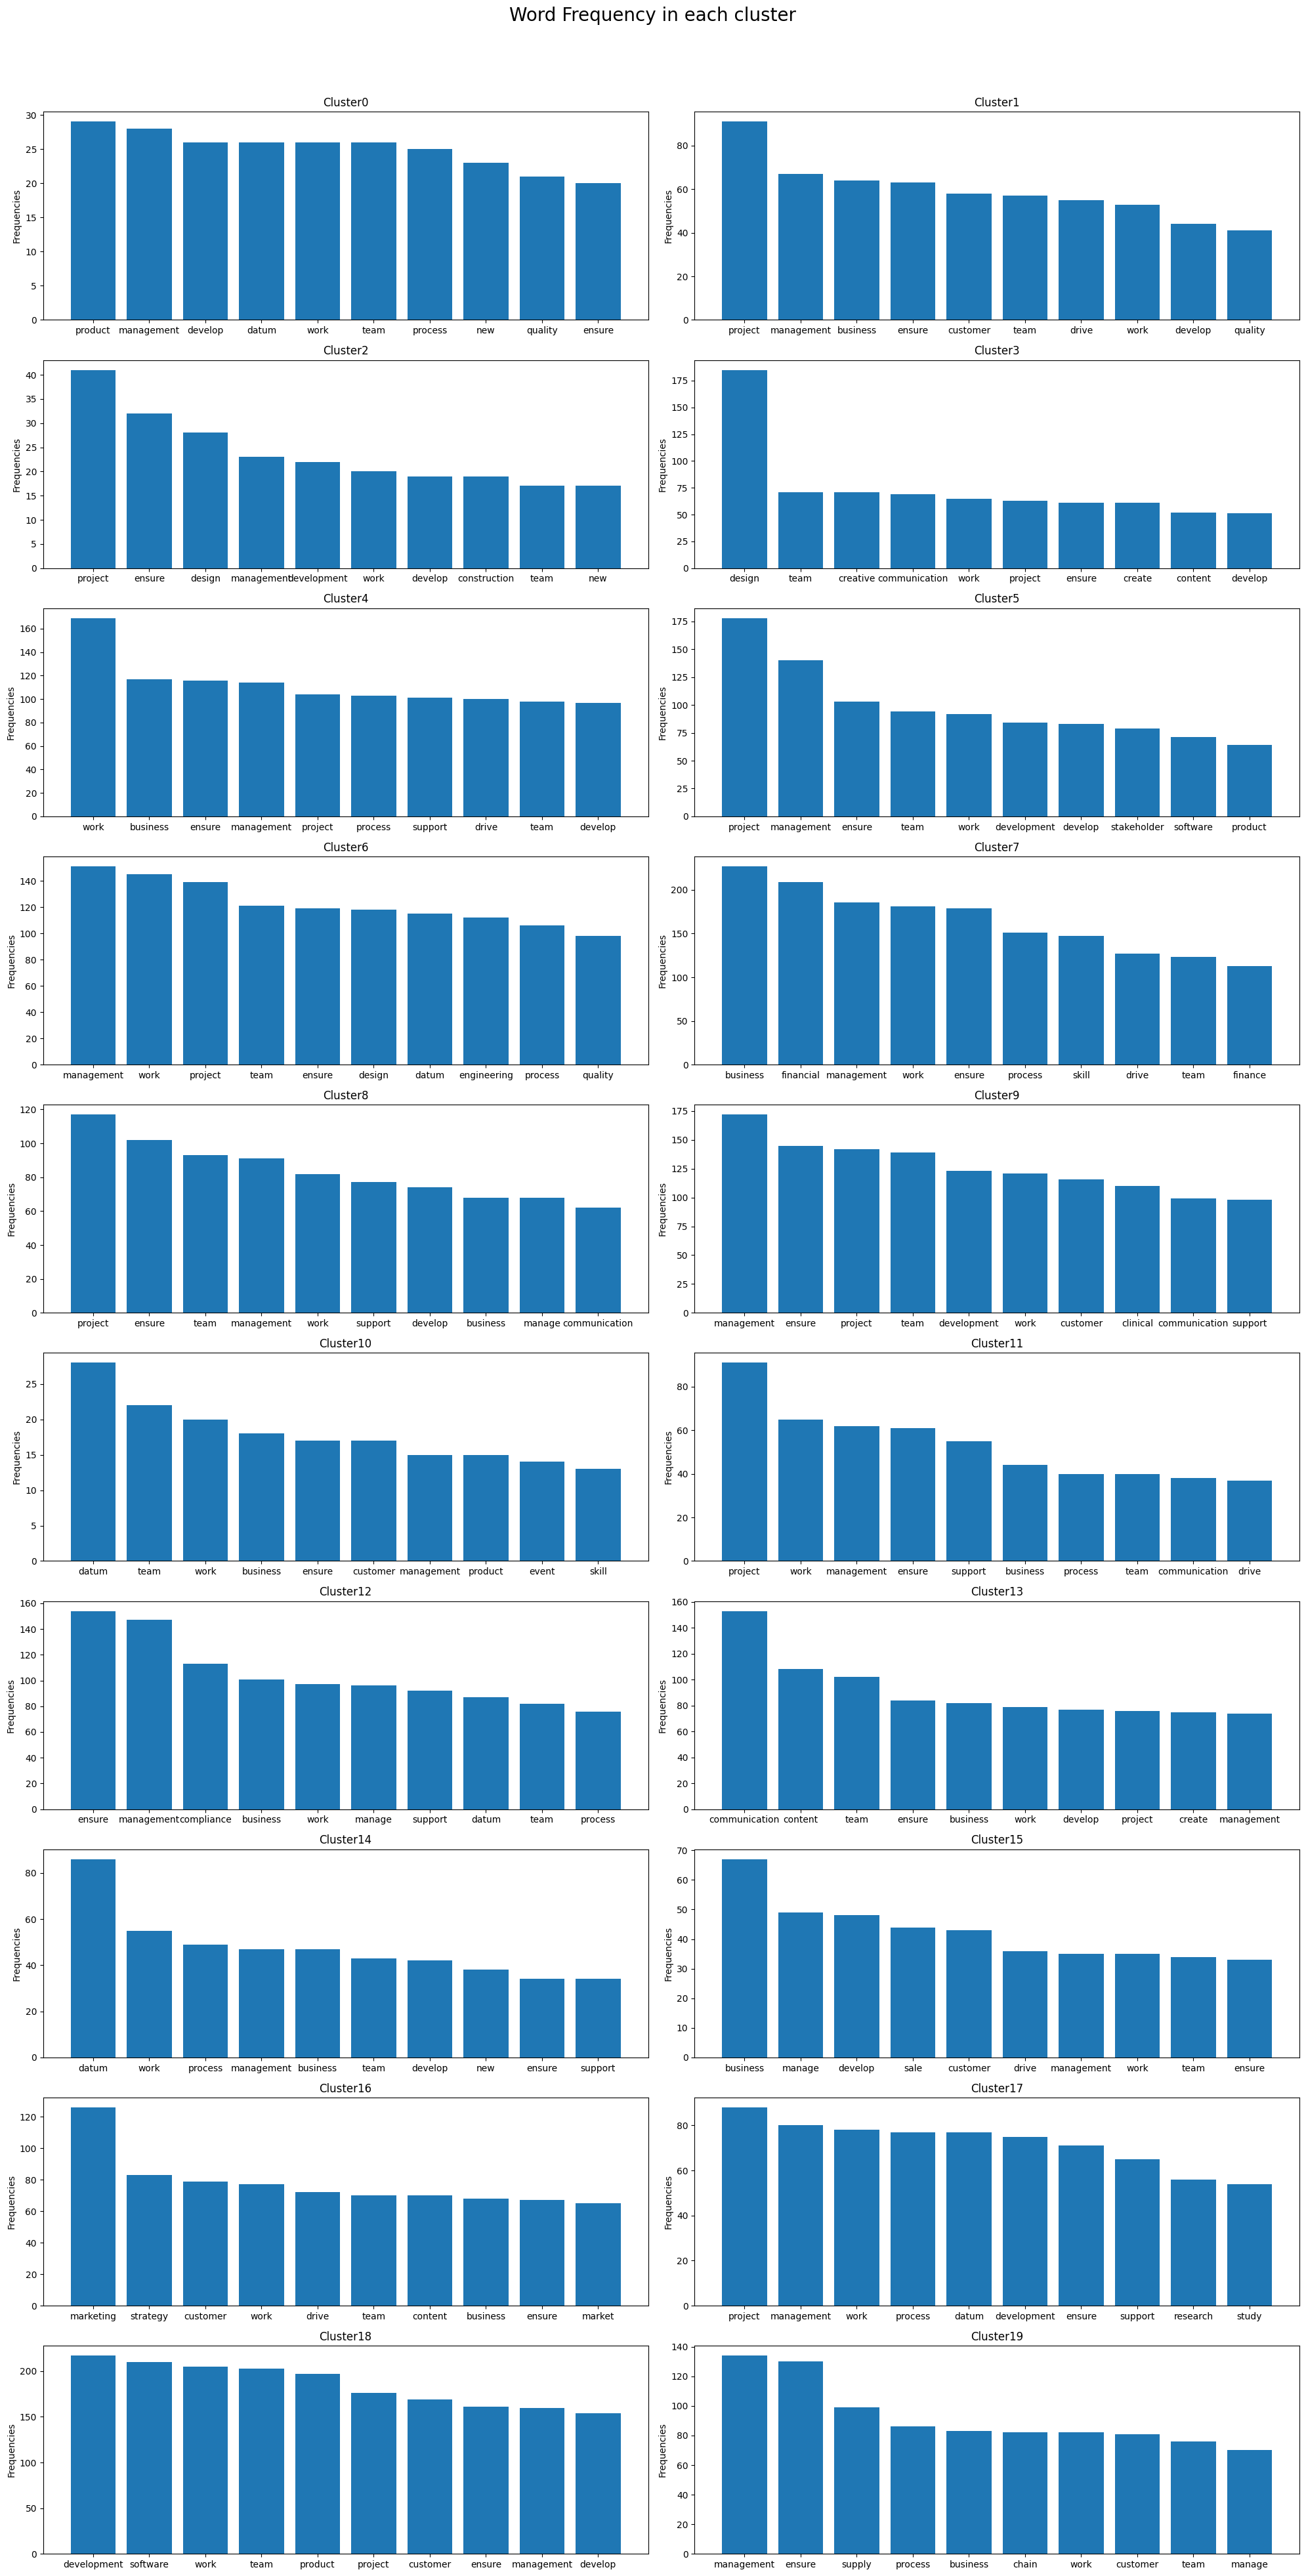

In [26]:
plot_frequency_histogram(skills, 'wordfrequency_histogram_ground.jpg', 10)